In [ ]:
!pip install -q torch_geometric pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.0+cu121.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.4/943.4 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch_geometric
from torch_geometric.datasets import Planetoid
import numpy as np
from tqdm.auto import trange
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/libpyg.so: undefined symbol: _ZN3c1010Dispatcher17runRecordFunctionERN2at14RecordFunctionESt17reference_wrapperIKNS_14FunctionSchemaEENS_11DispatchKeyE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_clu

In [ ]:
dataset = Planetoid(root=".",name= "Cora")

Processing...
Done!


In [ ]:
print("edge_index:\t\t",dataset.data.edge_index.shape)
print(dataset.data.edge_index)
print("\n")
print("train_mask:\t\t",dataset.data.train_mask.shape)
print(dataset.data.train_mask)
print("\n")
print("x:\t\t",dataset.data.x.shape)
print(dataset.data.x)
print("\n")
print("y:\t\t",dataset.data.y.shape)
print(dataset.data.y)

edge_index:		 torch.Size([2, 10556])
tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])


train_mask:		 torch.Size([2708])
tensor([ True,  True,  True,  ..., False, False, False])


x:		 torch.Size([2708, 1433])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


y:		 torch.Size([2708])
tensor([3, 4, 4,  ..., 3, 3, 3])


/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [ ]:



dataset = Planetoid(root=".", name="Cora")
idx = dataset.data.edge_index.T

# Create an adjacency matrix
num_nodes = dataset.data.x.shape[0]
adjacency_matrix = np.zeros((num_nodes, num_nodes))

for edge in idx:
    source_node = edge[0]
    target_node = edge[1]
    adjacency_matrix[source_node, target_node] = 1

adjacency_matrix = torch.from_numpy(adjacency_matrix)
X = dataset.data.x.float()

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [ ]:
class GCNLayer(nn.Module):
    def __init__(self, d_in, d_out):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(d_in, d_out)


    def forward(self, inp):
        x, adjacency_matrix = inp
        adjacency_matrix = adjacency_matrix + torch.eye(adjacency_matrix.shape[0]).to(adjacency_matrix.device) ## adding the node itself for aggregation
        D =  torch.diag(adjacency_matrix.sum(axis=1).pow(-0.5))## evaluating node ranks
        L = D @ adjacency_matrix @ D # evaluating normalization factor
        x = L@x
        x = self.linear(x)
        return x

class GNN(nn.Module):
    def __init__(self, d_in, d_hidden, n_classes, num_layers):
        super(GNN, self).__init__()
        layers = []
        d_out = d_hidden
        for i in range(num_layers):


            layers.append(GCNLayer(d_in, d_out))
            d_in = d_out
            d_out = d_hidden if i < num_layers - 2 else n_classes

        self.layers = nn.ModuleList(layers)


    def forward(self, x, adjacency_matrix):
        for i,layer in enumerate(self.layers):
            x = layer((x, adjacency_matrix))

            if i < len(self.layers) - 1:
                x = nn.functional.relu(x)
        return x

In [ ]:
model = GNN(dataset.num_features, 16, dataset.num_classes, 2).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
loss = []
acc = []
epochs = 500
def train():
    model.train()
    optimizer.zero_grad()
    out = model(dataset.data.x.float().cuda(), adjacency_matrix.float().cuda())
    loss = criterion(out[dataset.data.train_mask], dataset.data.y[dataset.data.train_mask].cuda())
    loss.backward()
    optimizer.step()
    return loss.item()
def eval():
    with torch.no_grad():
        model.eval()
        out = model(dataset.data.x.float().cuda(), adjacency_matrix.float().cuda())
        pred = out.argmax(dim=1)
        test_correct = pred[dataset.data.test_mask] == dataset.data.y[dataset.data.test_mask].cuda()
        return test_correct.sum().item() / test_correct.shape[0]

In [ ]:
loop = trange(epochs)
for epoch in loop:
    loss.append(train())
    acc.append(eval())
    loop.set_description(f"Epoch {epoch+1}")
    loop.set_postfix(loss=loss[-1], acc=acc[-1])

  0%|          | 0/500 [00:00<?, ?it/s]

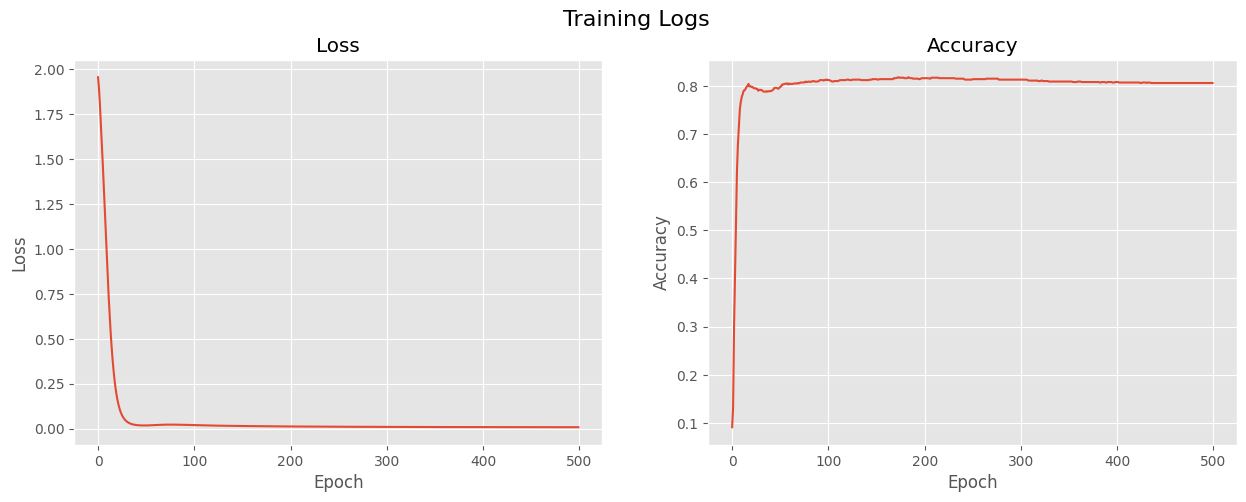

In [ ]:
plt.style.use('ggplot')
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Training Logs', fontsize=16)


axes[0].plot(loss)
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

axes[1].plot(acc)
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)

plt.show()

In [ ]:
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, n_heads, reduction="mean", dropout=0.5):
        super(GATLayer, self).__init__()

        self.W = nn.Parameter(torch.empty(size=(n_heads,in_features, out_features)))
        self.a = nn.Parameter(torch.empty(size=(n_heads,2 * out_features, 1)))
        self.num_heads = n_heads
        nn.init.xavier_uniform_(self.W.data, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.a.data, gain=nn.init.calculate_gain('relu'))
        self.dropout = dropout
        self.leakyrelu = nn.LeakyReLU()
        self.softmax = nn.Softmax(dim=-1)
        self.reduction = lambda x: x.mean(0) if reduction=="mean" else lambda x: x

    def forward(self, X, adjacency_matrix):
        Wh = torch.einsum("ij,hjk->hik", X, self.W)
        Wh = Wh.permute(1, 0, 2)
        row, col = adjacency_matrix.to_sparse().indices()
        Wh_i = Wh[row]
        Wh_j = Wh[col]
        Wh_concat = torch.cat([Wh_i, Wh_j], dim=-1)

        e  = self.leakyrelu(torch.einsum("ihj,hjk->ihk", Wh_concat, self.a))
        adj = adjacency_matrix.to_sparse()
        attention = torch.zeros([self.num_heads,Wh.shape[0], Wh.shape[0]],device=e.device)
        for i in range(self.num_heads):
            attention[i] = torch.sparse_coo_tensor(adj.indices(),
                                e[:,i,:].squeeze(1),
                                adj.size()).to_dense().unsqueeze(0)

        attention = nn.functional.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.einsum("ijk,kil->ijl", attention, Wh)
        h_prime = self.reduction(h_prime)

        return h_prime

class GAT(nn.Module):
    def __init__(self, in_features, hidden_dim, num_classes, n_heads, n_layers, dropout=0.5):
        super(GAT, self).__init__()
        self.layers = nn.ModuleList()
        # out_features =hidden_dim
        for i in range(n_layers):
            out_features = hidden_dim if i < n_layers - 1 else num_classes
            self.layers.append(GATLayer(in_features,
                                        out_features,
                                        n_heads,
                                        reduction="mean",
                                        dropout=dropout))
            in_features = out_features

    def forward(self, X, adjacency_matrix):
        for layer in self.layers:
            X = layer(X, adjacency_matrix)
        return X



In [ ]:
model = GAT(X.shape[1], X.shape[1]//2, dataset.num_classes, 8, 2).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
loss = []
acc = []
epochs = 150
def train():
    model.train()
    optimizer.zero_grad()
    out = model(dataset.data.x.float().cuda(), adjacency_matrix.float().cuda())
    loss = criterion(out[dataset.data.train_mask], dataset.data.y[dataset.data.train_mask].cuda())
    loss.backward()
    optimizer.step()
    return loss.item()
def eval():
    with torch.no_grad():
        model.eval()
        out = model(dataset.data.x.float().cuda(), adjacency_matrix.float().cuda())
        pred = out.argmax(dim=1)
        test_correct = pred[dataset.data.test_mask] == dataset.data.y[dataset.data.test_mask].cuda()
        return test_correct.sum().item() / test_correct.shape[0]


loop = trange(epochs)
for epoch in loop:
    loss.append(train())
    acc.append(eval())
    loop.set_description(f"Epoch {epoch+1}")
    loop.set_postfix(loss=loss[-1], acc=acc[-1])

  0%|          | 0/150 [00:00<?, ?it/s]

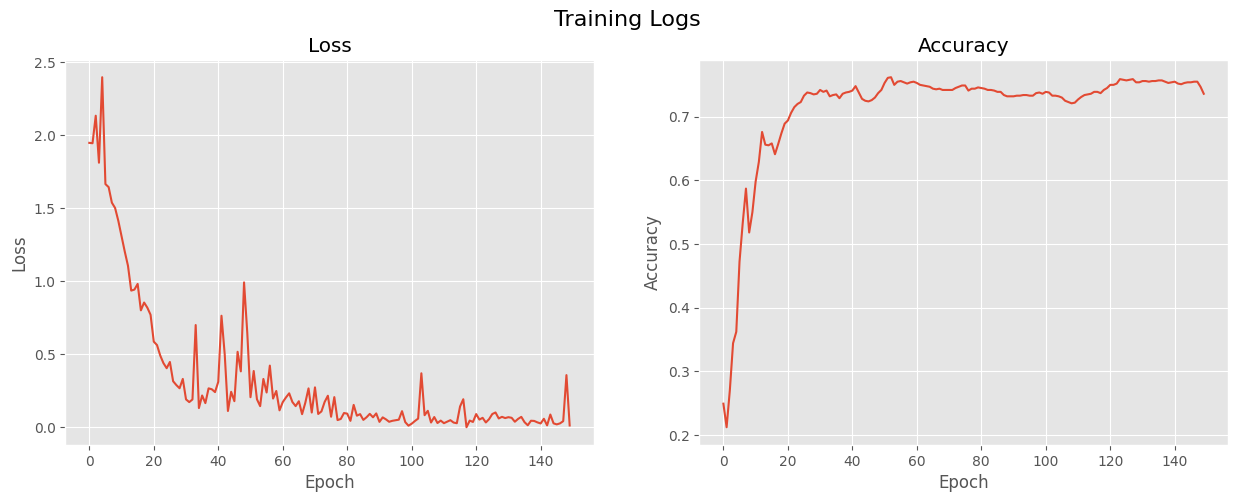

In [ ]:
plt.style.use('ggplot')
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Training Logs', fontsize=16)


axes[0].plot(loss)
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

axes[1].plot(acc)
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)

plt.show()

In [ ]:


class SageConvLayer(nn.Module):
    def __init__(self, in_dim, out_dim, aggregator):
        super(SageConvLayer, self).__init__()

        self.aggregator = aggregator
        self.W_out = nn.Sequential(nn.Linear(out_dim*2, out_dim), nn.ReLU())

    def forward(self, X, neighbors):
        assert len(neighbors.shape ) == 3, "nighbors must have the following dimensions (batch, n_nighbors, featurs)"

        h_n = self.aggregator(neighbors)

        h = self.W_out(torch.cat([X,h_n],dim=-1))
        h = h/torch.norm(h,2,dim=1, keepdim=True)
        return h

class SageConv(nn.Module):
    def __init__(self, in_dim, out_dim, depth, n_nieghbors, aggregator):
        super(SageConv, self).__init__()
        self.depth = depth
        self.conv = SageConvLayer(in_dim, out_dim, aggregator)
        self.n_neighbors = n_nieghbors
        self.W_in = nn.Linear(in_dim, out_dim, bias=False)

    def sample_neighbors_recursive(self, node, adjacency_matrix, depth, current_depth=0, sampled_nodes=None):
            if current_depth == depth:
                return sampled_nodes if sampled_nodes is not None else []

            if sampled_nodes is None:
                sampled_nodes = {node}

            neighbors = adjacency_matrix[node].nonzero()

            if neighbors.size(0) == 0:
                return sampled_nodes if sampled_nodes is not None else []

            neighbors = neighbors.squeeze()
            if neighbors.dim() == 0:
                neighbors = neighbors.unsqueeze(0)

            neighbors = neighbors.cpu().numpy()
            num_neighbors_to_sample = min(self.n_neighbors, neighbors.shape[0])
            sampled_neighbors = np.random.choice(neighbors, size=num_neighbors_to_sample, replace=False)
            sampled_nodes.update(sampled_neighbors)

            for neighbor in sampled_neighbors:
                sampled_nodes.update(self.sample_neighbors_recursive(neighbor, adjacency_matrix, depth, current_depth + 1, sampled_nodes))

            return list(sampled_nodes)

    def forward(self, X, adjacency_matrix):
        X = self.W_in(X)
        for _ in range(self.depth):
            neighbors_features = []
            for node in range(X.shape[0]):
                neighbors_idx = self.sample_neighbors_recursive(node, adjacency_matrix, self.depth)
                neighbors_idx = [n for n in neighbors_idx if n != node]
                if len(neighbors_idx) < self.n_neighbors:
                    neighbors_idx.extend([neighbors_idx[-1]] * (self.n_neighbors - len(neighbors_idx)))
                neighbors_features.append(X[neighbors_idx[:self.n_neighbors]].reshape(1, self.n_neighbors, -1))

            neighbors_features = torch.cat(neighbors_features, dim=0)
            X = self.conv(X, neighbors_features)


        return X

class MeanAggregator(nn.Module):
    def __init__(self):
        super(MeanAggregator, self).__init__()
    def forward(self, X):
        return X.mean(1)

class MaxPoolAggregator(nn.Module):
    def __init__(self, in_dim):
        super(MaxPoolAggregator, self).__init__()
        self.layer = nn.Sequential(nn.Linear(in_dim,in_dim), nn.ReLU())
    def forward(self, X):
        X = self.layer(X)
        # print(X.shape)

        return X.max(dim=1)[0]



class GraphSAGE(nn.Module):
    def __init__(self, in_features,
                 hidden_dim,
                 num_classes,
                 n_layers,
                 aggregator="mean",
                 depth=2,
                 n_neighbors=2):
        super(GraphSAGE, self).__init__()
        aggregator = aggregator.lower()
        assert aggregator in ["mean", "maxpool", ], "aggregator can only be {mean, maxpool}"

        self.layers = nn.ModuleList()
        self.aggregator = aggregator
        for i in range(n_layers):
            out_features = hidden_dim if i < n_layers - 1 else num_classes
            self.layers.append(self.make_layer( in_features, out_features,depth, n_neighbors, aggregator))
            in_features = out_features

    def forward(self, X, neighbors):
        for layer in self.layers:
            X = layer(X, adjacency_matrix)
        return X
    def make_layer(self, in_dim, out_dim,depth, n_nieghbors, aggregator):
        aggregator = self.aggregator
        aggregator = MaxPoolAggregator(out_dim) if aggregator == "maxpool" else MeanAggregator()
        return SageConv(in_dim, out_dim,depth, n_nieghbors, aggregator)

model=  GraphSAGE(in_features=X.shape[1],
                  hidden_dim=X.shape[1]//2,
                  num_classes=dataset.num_classes,
                  n_layers=2,
                  depth=2,
                  n_neighbors=2,
                  aggregator="maxpool").cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
loss = []
acc = []
epochs = 20
def train():
    model.train()
    optimizer.zero_grad()
    out = model(dataset.data.x.float().cuda(), adjacency_matrix.float().cuda())
    loss = criterion(out[dataset.data.train_mask], dataset.data.y[dataset.data.train_mask].cuda())
    loss.backward()
    optimizer.step()
    return loss.item()
def eval():
    with torch.no_grad():
        model.eval()
        out = model(dataset.data.x.float().cuda(), adjacency_matrix.float().cuda())
        pred = out.argmax(dim=1)
        test_correct = pred[dataset.data.test_mask] == dataset.data.y[dataset.data.test_mask].cuda()
        return test_correct.sum().item() / test_correct.shape[0]


loop = trange(epochs)
for epoch in loop:
    loss.append(train())
    acc.append(eval())
    loop.set_description(f"Epoch {epoch+1}")
    loop.set_postfix(loss=loss[-1], acc=acc[-1])

  0%|          | 0/20 [00:00<?, ?it/s]

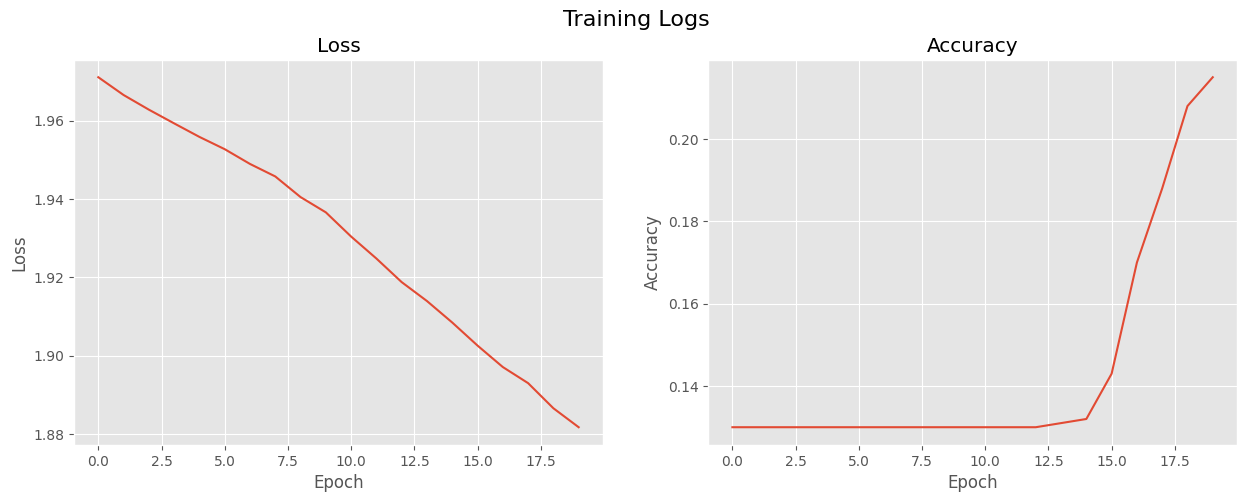

In [ ]:
plt.style.use('ggplot')
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Training Logs', fontsize=16)


axes[0].plot(loss)
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

axes[1].plot(acc)
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)

plt.show()